In [8]:
import os
import joblib
import pandas as pd
from util import show_metrics, prepare_final, set_seed

RANDOM_STATE = 42
set_seed(RANDOM_STATE)
current_dir = os.getcwd()
model_paths = ['rf_model.joblib', 'rf_selected_model.joblib', 'svm_selected_model.joblib', 'xgb_model.joblib', 'xgb_selected_model.joblib']
models = {path: joblib.load(os.path.join(current_dir, 'trained', path)) for path in model_paths}

final_path = os.path.join(current_dir, '..', 'data', 'final', 'final.csv')
selected_path = os.path.join(current_dir, '..', 'data', 'final', 'selected.csv')

final_df = prepare_final(pd.read_csv(final_path))
selected_df = pd.read_csv(selected_path).drop(columns=['user_id']).values

In [9]:
from sklearn.model_selection import train_test_split

X = final_df.drop('premium_user', axis=1).values
y = final_df['premium_user'].values

_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
_, X_test_selected, _, _ = train_test_split(selected_df, y, test_size=0.2, random_state=RANDOM_STATE)

# Porównanie modeli

Modele będą porównanywane na podstawie metryk takich jak Accuracy, ROC AUC, Precision, Recall i F1 Score dla danych używanych wcześniej do walidacji. Kładziemy największy nacisk na metrykę ROC AUC, a następnie na Recall (maksymalizacja TP i minimalizacja FN). 

Jako model bazowy służy nam klasyfikator Random Forest. Na jego podstawie zostały wyselekcjonowane atrybuty dla pozostałych modeli.

### Random Forest (model bazowy)

- bez selekcji atrybutów

d:\_prog\Projekty\Account-Classifier\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\_prog\Projekty\Account-Classifier\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.8050
ROC AUC: 0.8671
Precision: 0.8101
Recall: 0.6956
F1 Score: 0.7485


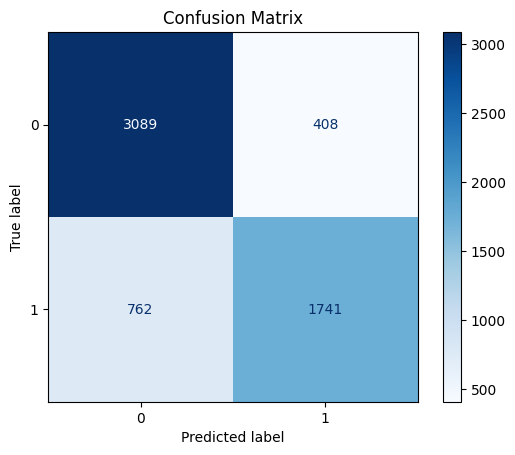

In [10]:
model = models['rf_model.joblib']

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

show_metrics(y_test, y_pred, y_pred_proba)

- po selekcji atrybutów

d:\_prog\Projekty\Account-Classifier\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\_prog\Projekty\Account-Classifier\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.8053
ROC AUC: 0.8712
Precision: 0.8083
Recall: 0.6992
F1 Score: 0.7498


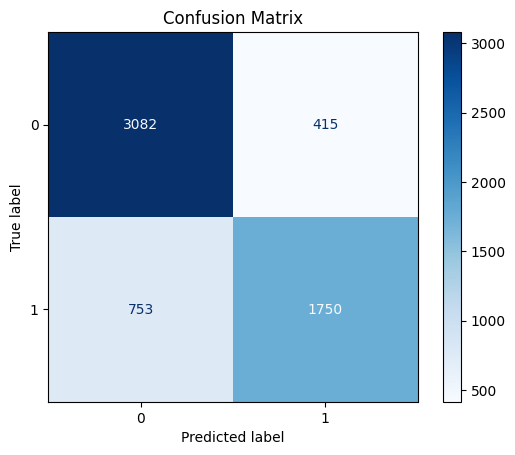

In [11]:
model = models['rf_selected_model.joblib']

y_pred = model.predict(X_test_selected)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

show_metrics(y_test, y_pred, y_pred_proba)

### XGBoost (model zaawansowany)

- bez selekcji atrybutów

Accuracy: 0.8110
ROC AUC: 0.8741
Precision: 0.8153
Recall: 0.7072
F1 Score: 0.7574


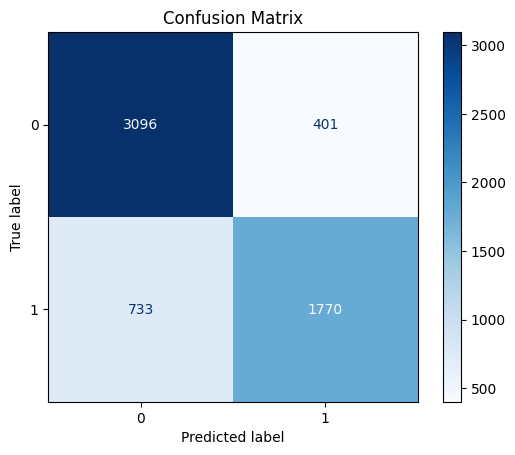

In [12]:
model = models['xgb_model.joblib']

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

show_metrics(y_test, y_pred, y_pred_proba)

- po selekcji atrybutów

Accuracy: 0.8105
ROC AUC: 0.8752
Precision: 0.8153
Recall: 0.7056
F1 Score: 0.7565


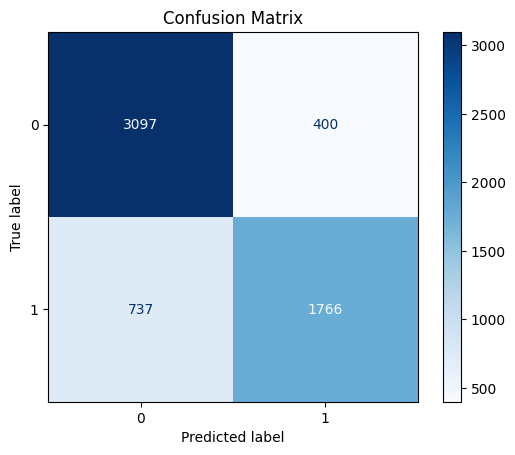

In [13]:
model = models['xgb_selected_model.joblib']

y_pred = model.predict(X_test_selected)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

show_metrics(y_test, y_pred, y_pred_proba)

### Support Vector Machine (model alternatywny dla XGBoost, po selekcji atrybutów)

Accuracy: 0.7982
ROC AUC: 0.8641
Precision: 0.8217
Recall: 0.6592
F1 Score: 0.7315


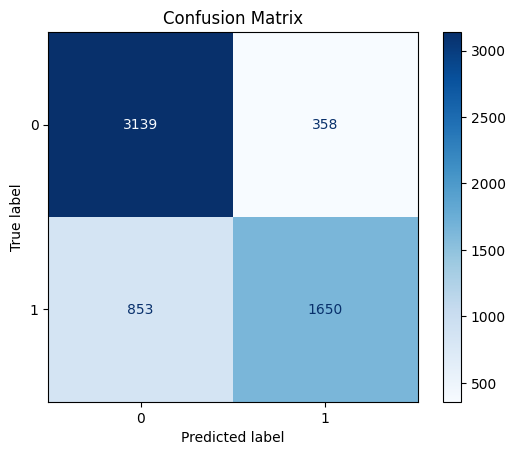

In [14]:
model = models['svm_selected_model.joblib']

y_pred = model.predict(X_test_selected)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

show_metrics(y_test, y_pred, y_pred_proba)

## Wyniki

| Model            | Accuracy   | ROC AUC    | Precission | Recall     | F1 Score   |
|------------------|------------|------------|------------|------------|------------|
| RF bez selekcji  | 0.8050     | 0.8671     | 0.8101     | 0.6956     | 0.7485     |
| RF z selekcją    | 0.8053     | 0.8712     | 0.8083     | 0.6992     | 0.7498     |
| XGB bez selekcji | **0.8110** | 0.8741     | 0.8153     | **0.7072** | **0.7574** |
| XGB z selekcją   | 0.8105     | **0.8752** | 0.8153     | 0.7056     | 0.7565     |
| SVM z selekcją   | 0.7982     | 0.8641     | **0.8217** | 0.6592     | 0.7315     |

## Analiza Wyników

### Random Forest (RF)
W przypadku modeli bazowych typu Random Forest, model z wyselekcjonowaną liczbą atrybutów radzi sobie nieznacznie lepiej od modelu bez tej selekcji w ważnych dla nas metrykach, takich jak ROC AUC i Recall. Konkretnie, model z selekcją cech osiąga lepszy wynik ROC AUC (0.8712 vs 0.8671) oraz nieco wyższy Recall (0.6992 vs 0.6956). Model ten jest również mniej złożony pod względem liczby używanych estymatorów, co przekłada się na szybsze działanie i mniejsze zużycie pamięci. Obydwa modele osiągają wymagany przez nas próg ROC AUC 0.5, a nawet znacznie go przekraczają, co oznacza, że spełniają założone przez nas kryterium sukcesu. Warto również zauważyć, że model RF bez selekcji był bardzo pomocny w procesie wyselekcjonowania istotnych atrybutów.

### XGBoost (XGB) i Support Vector Machine (SVM)

Wśród modeli bardziej zaawansowanych, takich jak XGBoost i Support Vector Machine, modele typu XGBoost dominują nad SVM w większości mierzonych metryk. Szczególnie wyróżniają się w kluczowych dla nas wskaźnikach ROC AUC i Recall. Na przykład, XGB bez selekcji osiąga najwyższą wartość ROC AUC (0.8741) oraz Recall (0.7072), podczas gdy SVM ma niższe wyniki w obu tych kategoriach (ROC AUC 0.8641, Recall 0.6592).

Wariant XGBoost z selekcją atrybutów osiąga jeszcze lepszy wynik ROC AUC (0.8752) niż jego odpowiednik bez selekcji, co czyni go naszym preferowanym wyborem jako model zaawansowany. Modele te, osiągając wartości ROC AUC na poziomie ponad 0.75, spełniają przyjęte przez nas kryterium sukcesu dla modeli zaawansowanych.